In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
pip install scikit-optimize

In [ ]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

In [ ]:
df = pd.read_csv('/content/drive/My Drive/FORCE_Facies/C4_training.csv')

In [ ]:
df.describe()

,Unnamed: 0,DEPTH_MD,X_LOC,Y_LOC,Z_LOC,CALI,RSHA,RMED,RDEP,RHOB,GR,SGR,NPHI,PEF,DTC,SP,BS,ROP,DTS,DCAL,DRHO,MUDWEIGHT,RMIC,ROPA,RXO,FORCE_2020_LITHOFACIES_LITHOLOGY,FORCE_2020_LITHOFACIES_CONFIDENCE,Log_RDEP,Log_RMED
count,1.756140e+05,175614.000000,168222.000000,1.682220e+05,168222.000000,175352.000000,113948.000000,159704.000000,168222.000000,175614.000000,175614.000000,17350.000000,175614.000000,175614.000000,175614.000000,175614.000000,97563.000000,172822.000000,6556.000000,80255.000000,144408.000000,161957.000000,0.0,4805.000000,43415.000000,175614.000000,175596.000000,175614.000000,175614.000000
mean,1.152380e+05,1830.033819,455666.724753,6.462144e+06,-1777.649642,13.688447,25.952544,2.187289,45.229261,2.166009,64.567342,59.813135,0.371598,5.450987,120.917327,87.463690,12.582336,33.196443,153.686679,2.071115,0.014824,1.760229,NaN,23.372037,-96.731579,63574.870489,1.218718,0.172444,0.169301
std,1.317188e+05,753.278483,25729.093684,1.842443e+04,756.252640,3.480000,178.390558,24.990300,276.713635,0.236994,35.837982,25.538669,0.147554,5.957969,34.746590,78.164370,3.112300,72.034806,13.269154,104.882098,0.062637,14.186789,NaN,7.501500,323.855787,13993.658527,0.485866,0.589412,0.491071
min,0.000000e+00,162.593016,436790.843750,6.421578e+06,-3246.156250,5.946157,0.005141,-0.008419,0.087607,1.343777,0.109284,-196.869995,-0.023143,-4.410029,7.415132,-2.199269,8.500000,0.018832,109.256126,-12.215459,-1.795894,0.125818,NaN,0.556113,-999.900024,30000.000000,1.000000,-1.057460,-1.189528
25%,4.390325e+04,1225.839062,438593.968750,6.452288e+06,-2420.333557,12.207208,0.717646,0.776958,0.747340,1.994043,40.987764,41.281138,0.252784,2.940292,87.131342,45.670704,12.250001,3.975974,143.911385,0.039300,-0.006000,0.141395,NaN,18.091204,0.527370,65000.000000,1.000000,-0.119238,-0.095687
50%,9.316350e+04,1840.110398,444920.343750,6.462992e+06,-1761.966431,13.012215,0.939032,1.112542,1.155919,2.118043,63.814432,62.973612,0.426183,4.453916,133.006470,73.630066,12.250001,16.044679,156.334686,0.495774,0.006712,0.155774,NaN,24.534739,0.869258,65000.000000,1.000000,0.073176,0.068290
75%,1.699588e+05,2470.146147,460425.343750,6.470982e+06,-1167.600311,15.955509,1.346923,1.648979,1.688341,2.354990,83.280855,73.933750,0.496871,6.096446,147.722992,100.208622,14.750000,35.019391,162.949692,1.412014,0.034699,1.138351,NaN,29.426481,1.582943,65030.000000,1.000000,0.254242,0.265049
max,1.170510e+06,3272.024000,520153.187500,6.500268e+06,-135.593018,25.806299,2193.904541,1841.164062,1999.887085,3.054074,804.298950,152.516830,0.817310,365.575592,230.432953,526.547302,26.000002,2224.647461,190.500519,10011.422852,0.323460,185.730927,NaN,40.068165,2000.000000,99000.000000,3.000000,3.301005,3.265092


In [ ]:
lithology_keys = {30000: 'Sandstone',
                 65030: 'Sandstone/Shale',
                 65000: 'Shale',
                 80000: 'Marl',
                 74000: 'Dolomite',
                 70000: 'Limestone',
                 70032: 'Chalk',
                 88000: 'Halite',
                 86000: 'Anhydrite',
                 99000: 'Tuff',
                 90000: 'Coal',
                 93000: 'Basement'}

In [ ]:
# specify some data types may python concern about
df['FORCE_2020_LITHOFACIES_LITHOLOGY'] = df['FORCE_2020_LITHOFACIES_LITHOLOGY'].astype('int')
df['DEPTH_MD'] = df['DEPTH_MD'].astype('float')
df['WELL'] = df['WELL'].astype('category')
df['FORMATION'] = df['FORMATION'].astype('category')
df['GROUP'] = df['GROUP'].astype('category')

In [ ]:
dummies = pd.get_dummies(df['FORCE_2020_LITHOFACIES_LITHOLOGY'])                        
Facies_cat = dummies.columns
labels = dummies.values # target matirx

In [ ]:
# select predictors
features = df[['GR','RHOB','NPHI','DTC','PEF','SP','Log_RDEP','Log_RMED']]

In [ ]:
features.head()

,GR,RHOB,NPHI,DTC,PEF,SP,Log_RDEP,Log_RMED
0,80.200851,1.884186,0.514642,161.131180,20.915468,24.612379,0.254954,0.207206
1,79.262886,1.889794,0.513352,160.603470,19.383013,23.895531,0.254220,0.208997
2,74.821999,1.896523,0.513352,160.173615,22.591518,23.916357,0.255449,0.211243
3,72.878922,1.891913,0.513352,160.149429,32.191910,23.793688,0.255638,0.209942
4,71.729141,1.880034,0.514642,160.128342,38.495632,24.104078,0.254137,0.204847


In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(features)
scaled_features = scaler.transform(features)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=42)

In [ ]:
dim_learning_rate = Real(low=1e-6, high=1e-1, prior='log-uniform',
                         name='learning_rate')

In [ ]:
dim_num_dense_layers = Integer(low=1, high=10, name='num_dense_layers')

In [ ]:
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')


In [ ]:
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')

In [ ]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

In [ ]:
default_parameters = [1e-5, 1, 16, 'relu']

In [ ]:

# This is a function to log traning progress so that can be viewed by TnesorBoard.
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

In [ ]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    
    model = Sequential()

    model.add(InputLayer(input_shape=(scaled_features.shape[1])))
    
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)

        # add dense layer
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # use softmax-activation for classification.
    model.add(Dense(labels.shape[1], activation='softmax'))
    
    # Use the Adam method for training the network.
    optimizer = Adam(lr=learning_rate)
    
    #compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [ ]:
path_best_model = '19_best_model.h5'

In [ ]:

#define global variable to store accuracy
best_accuracy = 0.0

validation_data = (X_test, y_test)

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x= X_train,
                        y= y_train,
                        epochs=3,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy
# This function exactly comes from :Hvass-Labs, TensorFlow-Tutorials

In [ ]:
#Test with dafault parameters
fitness(x= default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
1098/1098 [==============================] - 3s 3ms/step - loss: 2.8353 - accuracy: 0.0412 - val_loss: 2.7847 - val_accuracy: 0.0428
Epoch 2/3
1098/1098 [==============================] - 3s 2ms/step - loss: 2.7344 - accuracy: 0.0441 - val_loss: 2.6871 - val_accuracy: 0.0451
Epoch 3/3
1098/1098 [==============================] - 3s 2ms/step - loss: 2.6402 - accuracy: 0.0514 - val_loss: 2.5951 - val_accuracy: 0.0523

Accuracy: 5.23%



-0.05227343738079071

In [ ]:

%%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)
# you may examine other kind of minimization
# search_result = forest_minimize(func=fitness,
#                             dimensions=dimensions,
#                             base_estimator='RF', 
#                             n_calls=50,
#                             random_state=4)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
1098/1098 [==============================] - 3s 3ms/step - loss: 2.8063 - accuracy: 0.0643 - val_loss: 2.7524 - val_accuracy: 0.0743
Epoch 2/3
1098/1098 [==============================] - 3s 2ms/step - loss: 2.6935 - accuracy: 0.0933 - val_loss: 2.6424 - val_accuracy: 0.1168
Epoch 3/3
1098/1098 [==============================] - 3s 2ms/step - loss: 2.5870 - accuracy: 0.1454 - val_loss: 2.5381 - val_accuracy: 0.1764

Accuracy: 17.64%

learning rate: 4.8e-06
num_dense_layers: 5
num_dense_nodes: 195
activation: relu

Epoch 1/3
1098/1098 [==============================] - 3s 3ms/step - loss: 2.1341 - accuracy: 0.4991 - val_loss: 1.6064 - val_accuracy: 0.6282
Epoch 2/3
1098/1098 [==============================] - 3s 3ms/step - loss: 1.2656 - accuracy: 0.6600 - val_loss: 1.0766 - val_accuracy: 0.6905
Epoch 3/3
1098/1098 [==============================] - 3s 3ms/step - loss: 0.9838 - accuracy: 0.7106 - 

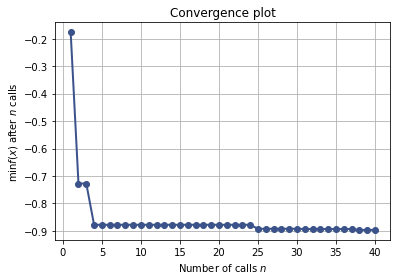

In [ ]:
plot_convergence(search_result) 
plt.savefig("Converge.png", dpi=400)

In [ ]:
search_result.x

[0.0015296177885123542, 5, 194, 'relu']

In [ ]:
# The best fitness value associated with these hyper-parameters
search_result.fun

-0.8966204524040222

In [ ]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.8966204524040222, [0.0015296177885123542, 5, 194, 'relu']),
 (-0.8952253460884094, [0.0016106736378413663, 5, 325, 'relu']),
 (-0.8934601545333862, [0.0006690132166990642, 8, 391, 'relu']),
 (-0.8924636244773865, [0.002009605822576807, 5, 387, 'relu']),
 (-0.892406702041626, [0.0030783882096453883, 5, 150, 'relu']),
 (-0.8898158073425293, [0.0010446835599764019, 8, 411, 'relu']),
 (-0.888363778591156, [0.0002473291363623178, 10, 401, 'relu']),
 (-0.883552074432373, [0.0008529831470230432, 7, 167, 'relu']),
 (-0.8780001997947693, [0.012448603980610241, 3, 370, 'relu']),
 (-0.874896764755249, [0.00597223302512055, 7, 380, 'relu']),
 (-0.8712524771690369, [0.005574615603223616, 1, 374, 'relu']),
 (-0.8647040128707886, [0.004460658721352783, 1, 391, 'relu']),
 (-0.8637360334396362, [0.0030155068985882973, 1, 287, 'relu']),
 (-0.860803484916687, [0.015455740551878507, 1, 121, 'sigmoid']),
 (-0.859636127948761, [0.015091982358330576, 1, 390, 'relu']),
 (-0.8548244833946228, [0.017358844

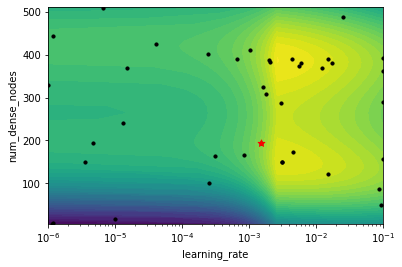

In [ ]:
from skopt.plots import plot_objective_2D
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_dense_nodes',
                        levels=50)
plt.savefig("Lr_numnods.png", dpi=400)

In [ ]:
# create a list for plotting
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation' ]

ValueError: ignored

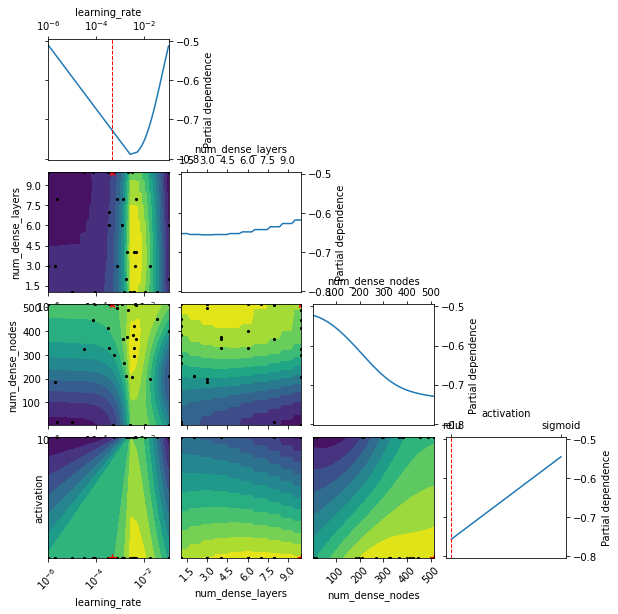

In [ ]:
fig, ax = plot_objective(result=search_result, dimensions=dim_names)
plt.savefig("all_dimen.png", dpi=400)

ValueError: ignored

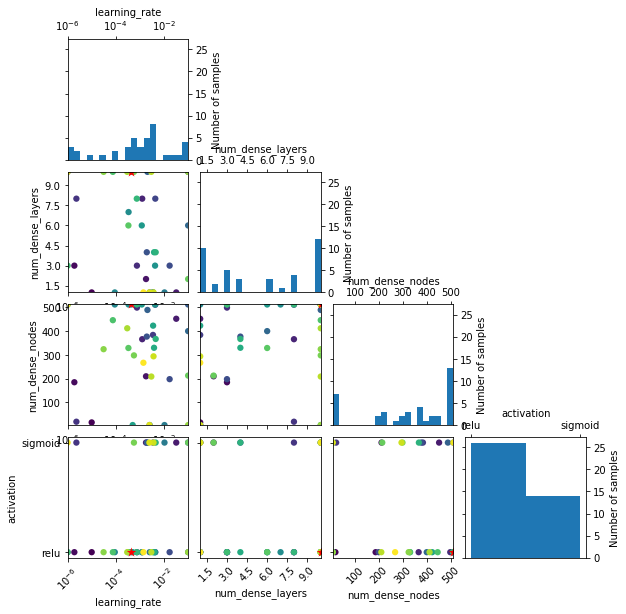

In [ ]:
fig, ax = plot_evaluations(result=search_result, dimensions=dim_names)

In [ ]:
best_model= load_model(path_best_model)

Load validation DATA

In [ ]:
blind = pd.read_csv('/content/drive/My Drive/FORCE_Facies/RESULTS/C4_complete.csv')

In [ ]:
blind['WELL'].unique()

array(['15/9-14'], dtype=object)

In [ ]:
# select predictors
features_blind = blind[['GR','RHOB','NPHI','DTC','PEF','SP','Log_RDEP','Log_RMED']]

In [ ]:
scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(features_blind)
scaled_features_blind = scaler.transform(features_blind)

In [ ]:
opt_par = search_result.x

In [ ]:
# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_layers = opt_par[1]
num_nodes = opt_par[2]
activation = opt_par[3]

In [ ]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(InputLayer(input_shape=(scaled_features.shape[1])))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dense(labels.shape[1], activation='softmax', kernel_initializer='random_normal'))

optimizer = Adam(lr=learning_rate)
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['accuracy'])


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(X_train,y_train, validation_data=(X_test,y_test),
          callbacks=[monitor],verbose=2,epochs=100)

Epoch 1/100
4391/4391 - 10s - loss: 0.6148 - accuracy: 0.8033 - val_loss: 0.5124 - val_accuracy: 0.8335
Epoch 2/100
4391/4391 - 10s - loss: 0.4903 - accuracy: 0.8384 - val_loss: 0.4703 - val_accuracy: 0.8432
Epoch 3/100
4391/4391 - 10s - loss: 0.4534 - accuracy: 0.8495 - val_loss: 0.4350 - val_accuracy: 0.8553
Epoch 4/100
4391/4391 - 10s - loss: 0.4302 - accuracy: 0.8571 - val_loss: 0.4227 - val_accuracy: 0.8609
Epoch 5/100
4391/4391 - 10s - loss: 0.4140 - accuracy: 0.8616 - val_loss: 0.4056 - val_accuracy: 0.8654
Epoch 6/100
4391/4391 - 10s - loss: 0.4014 - accuracy: 0.8666 - val_loss: 0.4006 - val_accuracy: 0.8681
Epoch 7/100
4391/4391 - 10s - loss: 0.3912 - accuracy: 0.8702 - val_loss: 0.3930 - val_accuracy: 0.8698
Epoch 8/100
4391/4391 - 10s - loss: 0.3827 - accuracy: 0.8725 - val_loss: 0.3769 - val_accuracy: 0.8747
Epoch 9/100
4391/4391 - 10s - loss: 0.3762 - accuracy: 0.8754 - val_loss: 0.3764 - val_accuracy: 0.8761
Epoch 10/100
4391/4391 - 10s - loss: 0.3711 - accuracy: 0.8764 -

In [ ]:
print(histories.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-6ke628p7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-6ke628p7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.01df2700eac33561cf29d0605ec82af0d59fbf6c1_-cp36-none-any.whl size=144260 sha256=ecff9f7129bfc6ceea99a6b5cff8a7c675f8dda8e3a978b6e1c587ef60bbe37b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nd98syag/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
import pathlib
import shutil
import tempfile

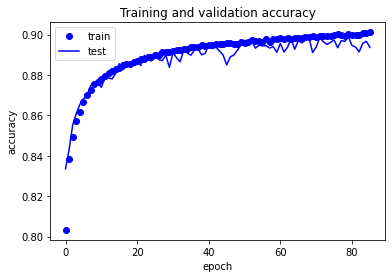

In [ ]:
plt.plot(histories.history['accuracy'], 'bo')
plt.plot(histories.history['val_accuracy'],'b' )
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("accu.png", dpi=400)
plt.show()

In [ ]:
y_pred = model.predict(scaled_features_blind)
y_pred_idx = np.argmax(y_pred, axis=1)

In [ ]:
blind['Pred_Facies']= y_pred_idx

In [ ]:
test_prediction=blind['Pred_Facies']
test_prediction

0        1
1        1
2        1
3        1
4        1
        ..
20276    1
20277    1
20278    1
20279    1
20280    1
Name: Pred_Facies, Length: 20281, dtype: int64

In [ ]:
lithology_numbers = {0: 30000,
                 1: 65030,
                 2: 65000,
                 3: 80000,
                 4: 74000,
                 5: 70000,
                 6: 70032,
                 7: 88000,
                 8: 86000,
                 9: 99000,
                 10: 90000,
                 11: 93000}

In [ ]:

test_prediction = test_prediction.map(lithology_numbers)

In [ ]:
test_prediction

0        65030
1        65030
2        65030
3        65030
4        65030
         ...  
20276    65030
20277    65030
20278    65030
20279    65030
20280    65030
Name: Pred_Facies, Length: 20281, dtype: int64

In [ ]:
Predictions=pd.DataFrame(test_prediction)
Predictions.to_csv('Facies_C4.csv')